
## ⚙️ Pre-requisite

> ✅ **Recommended Python version:** `Python >= 3.10`


### 🔑 Get a Free Gemini API Key

To use Gemini's AI services, follow these steps:

1. Visit 👉 [**Google AI Studio**](https://aistudio.google.com/)
2. Sign in using your **Google account**
3. Click on **“Get API Key”** in the top-right corner
4. Copy the generated API key
5. Create a `.env` file in your project directory and add the following line:

   ```env
   GEMINI_API_KEY=your_key_here
   ```

> ⚠️ **Important:**
> Never upload your `.env` file to GitHub or share it publicly — it contains sensitive credentials.


Once you've done this, your environment will be ready to use the Gemini API.


### Install required library (ONLY FOR THE FIRST TIME)

In [ ]:
# # uncomment and install necessary packages by running the following command
# %pip install google-generativeai
# %pip install pyvis
# %pip install networkx
# %pip install matplotlib
# %pip install dotenv
# %pip install openpyxl
# %pip install langchain
# %pip install langchain-google-genai
# %pip install langchain-experimental
# %pip install tabulate
# %pip install ipywidgets

In [2]:
import google.generativeai as genai
import os, time, json
import pandas as pd
from datetime import datetime
from IPython.display import Markdown, display, HTML
import networkx as nx
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import ipywidgets as widgets
import tempfile

# Load environment variables from .env file
load_dotenv()
genai.configure(api_key=os.getenv("GEMINI_API_KEY"))
model = genai.GenerativeModel(model_name="gemini-2.5-flash-preview-05-20")


### Test the AI model

In [3]:
prompt = "explain deep transition theory for sustainable investment founded by DTL in concise way like you explain to 5 years old kid"
response = model.generate_content(prompt,request_options={"timeout": 600})

# print the response in markdown format
display(Markdown(response.text))

Imagine our world is like a big toy box.

Sometimes, we have old toys that break easily, or maybe they don't share well, or they make a big mess.

**Deep Transition Theory**, from DTL, is like saying: "Instead of just gluing the broken toy back together or cleaning up the mess *again*... let's think really, really hard about what kind of **new, super-duper toys** we want! Toys that never break, that everyone can play with, and that don't make any mess at all, forever and ever!"

And **sustainable investment** is like the grown-ups deciding to spend their money on buying the *parts for these amazing new toys* and helping the people who invent them, instead of just buying more of the old, broken ones.

So it's about making big, important changes so that *everything* works better and lasts a long, long time, for *everyone*.

## Data Preparation


### 📂 Data Upload Instructions

Please follow these guidelines to ensure your data is correctly loaded:

* ✅ Place your Excel file in the following path:
  `data/input/your_data.xlsx`

* ⚠️ **Important:** Ensure your file follows the **exact format** of the template provided here:
  `data/input_example/template_example.xlsx`

* ❌ If more than one `.xlsx` file is placed in the `data/input/` directory, you'll be prompted to remove the extra files.



In [4]:
import os
import pandas as pd

# Directory containing input files
input_dir = "data/input"
xlsx_files = [f for f in os.listdir(input_dir) if f.endswith('.xlsx')]

# Handle multiple or missing files
if len(xlsx_files) == 0:
    raise FileNotFoundError("❌ No Excel (.xlsx) file found in /data/input. Please add one.")
elif len(xlsx_files) > 1:
    raise RuntimeError(f"❌ Multiple Excel files detected in /data/input:\n{xlsx_files}\nPlease keep only one.")

# Safe to proceed
input_file = os.path.join(input_dir, xlsx_files[0])
print(f"📄 Reading file: {input_file}")

# Read and normalize the Excel file
df = pd.read_excel(input_file, header=0)
df.columns = df.columns.str.lower()

df.head(2)


📄 Reading file: data/input\SNA-Dataset-template.xlsx


resource_name source_id  \
0  Dos décadas de esfuerzos colectivos para la co...        2A   
1  El impacto del represamiento del Río Colorado ...        2B   

                                                link  \
0                        wwflac.awsassets.panda.org​   
1  https://www.scielo.org.mx/scielo.php?script=sc...   

                                             systems  \
0  Socio-technical system(s): Shrimp Fishery Reas...   
1  Socio-technical system(s): Food (specifically ...   

                                         space_level  \
0  Spatial level: Municipality (or Province/Regio...   
1  Socio-technical system(s): Food (specifically ...   

                                              actors  \
0  Actor: Policy/Governance Actors Reason: Docume...   
1  Actor: Business Reason: Document 2B mentions t...   

                                              niches  \
0  Reviewing our analysis of Document 2A from the...   
1  Document 2B provides an analysis of the dynami...   

                                    landscape_factor  \
0  Landscape factor: Ecological damage / Loss of ...   
1  Landscape factor: Altered freshwater discharge...   

                                        regime_rules  \
0  Document 2A describes the Colorado River Water...   
1  Document 2B provides an empirical case study o...   

                                             ips_tos  \
0  •\nIP: IP7. Address the broader repercussions ...   
1  IP/TOr: IP8. Tilt the landscape Reason: Docume...   

                                 period_1971_to_1980  \
0  context:high demand of totoaba known as buche ...   
1  context: significant fresh water flow reductio...   

                                 period_1981_to_1990  \
0  1986: The IUCN listed the vaquita as vulnerabl...   
1  1987: The Infectious Hypodermal and Hematopoie...   

                                 period_1991_to_2000  \
0  1992: An area was established where gillnets f...   
1  1998: An El Niño event occurs, leading to an i...   

                                 period_2001_to_2010  \
0  2004: The Mexican National Institute of Fisher...   
1                                                NaN   

                                 period_2011_to_2019  \
0  2013: Illegal totoaba fishing exploded due to ...   
1                                                NaN   

                                        2020-present  
0  2020: WWF closed its office in the Upper Gulf ...  
1                                                NaN

In [ ]:
# Function to extract master data from a DataFrame using a prompt
def extract_master_data(df, prompt):
    df_str = ', '.join(df.astype(str))
    prompt = f'{prompt} from the following data: {df_str} and must return the result as a ready to use JSON object for dataframe with no nested data.'
    response = model.generate_content(prompt, request_options={"timeout": 600})
    # Extract only the JSON part from the response
    json_start = response.text.find("```json")
    json_end = response.text.find("```", json_start + 1)
    if json_start != -1 and json_end != -1:
        return json.loads(response.text[json_start + 7:json_end])
    else:
        raise ValueError("JSON block not found in response.")



### 📋 Collecting Master Data

This step gathers **master data** for the following components:

* 🔸 Niches
* 🔸 Regime rules
* 🔸 Events
* 🔸 Transformative outcomes

Each entry will be assigned a **unique ID** used as an identifier across the graph.
All generated master data will be saved to:
📁 `data/temp/maste_<data name>.csv`

> ⚠️ **Note:**
> Errors may occur if the data format (especially those generated by AI tools) does not match the expected structure.
> If that happens, simply **rerun the cell** after reviewing the output or input data.


In [6]:
# Connecting niches and systems with their respective IDs
df['niches_system'] = df.apply(lambda row: f"{row['niches']} || systems: {row['systems']}", axis=1)

master_niches = extract_master_data(df['niches_system'], 'generate unique niches with niche_name (containing short description of niche) , id (format: niche_<abreviation from description>) and systems (array of respective system)')
# make sure the master_niches contains the keys 'niche_name', 'id', and 'systems' and the format is correct for loading to dataframe, if not fulfill retry up to 3 times
for _ in range(3):
    try:
        df_master_niches = pd.DataFrame(master_niches)
        if 'niche_name' in df_master_niches.columns and 'id' in df_master_niches.columns and 'systems' in df_master_niches.columns:
            break
    except Exception as e:
        print(f"Error: {e}. Retrying...")
        time.sleep(2)
print(master_niches)

[{'niche_name': 'Marine Ecological Spatial Planning Program for the Gulf of California (MESPGOC)', 'id': 'niche_MESPGOC', 'systems': ['Marine Environment', 'Fishing', 'Tourism', 'Aquaculture', 'Governance']}, {'niche_name': 'Multi-sectoral Committee for Marine Ecological Planning (COMEMGC)', 'id': 'niche_COMEMGC', 'systems': ['Governance', 'Fishing', 'Tourism', 'Aquaculture', 'Conservation', 'Academia', 'Indigenous Groups']}, {'niche_name': 'Systematic Technical Studies (STS) (Caracterización, Diagnóstico, Pronóstico y Propuesta)', 'id': 'niche_STS', 'systems': ['Marine Environment', 'Social', 'Economic', 'Governance']}, {'niche_name': 'Environmental Management Units (UGAs) and Localized Problem Verification Workshops', 'id': 'niche_UGAs', 'systems': ['Environmental Management', 'Productive Sectors']}, {'niche_name': 'Environmental Logbook (EL) (Bitácora Ambiental)', 'id': 'niche_EL', 'systems': ['Governance', 'Various Sectors', 'Public']}, {'niche_name': 'Sustainable Ocean Economy (SO

In [7]:
master_regimes = extract_master_data(df['regime_rules'], 'generate unique regime_rule (containing short description of regime rules) and id (format: regime_<abreviation from description>)')
# make sure the master_regimes contains the keys 'regime_rule'and 'id and the format is correct for loading to dataframe, if not fulfill retry up to 3 times
for _ in range(3):
    try:
        df_master_regimes = pd.DataFrame(master_regimes)
        if 'regime_rule' in df_master_regimes.columns and 'id' in df_master_regimes.columns:
            break
    except Exception as e:
        print(f"Error: {e}. Retrying...")
        time.sleep(2)

print(master_regimes)

[{'id': 'regime_CRWMS_PrioritizeUpstreamStorage', 'regime_rule': 'Prioritize upstream water storage and regulated allocation in the Colorado River system.'}, {'id': 'regime_CRWMS_UtilizeLargeScaleInfra', 'regime_rule': 'Utilize large-scale infrastructure (dams) for Colorado River water control and management.'}, {'id': 'regime_SFR_ShrimpExtractionEco', 'regime_rule': 'Engage in the extraction of shrimp for economic purposes in the Upper Gulf.'}, {'id': 'regime_SFR_LivelihoodDependence', 'regime_rule': 'Depend on the shrimp fishery resource for livelihoods and economic activity in local communities.'}, {'id': 'regime_SFR_MaintainTraditionalPractices', 'regime_rule': 'Maintain traditional practices and ways of life associated with the shrimp fishery.'}, {'id': 'regime_MFR_ResourceStatusDiagnosis', 'regime_rule': 'Manage Mexican fisheries based on the diagnosis of resource status provided by institutions like INAPESCA.'}, {'id': 'regime_MFR_NationalFishingCharter', 'regime_rule': 'Impleme

In [ ]:
master_events = []
# create for loop for column name that contains 'period' and call extract_master_data function
for column in df.columns:
    if 'period' in column:
        master_event_temp = extract_master_data(df[column], f'generate unique events with id (format: evt_<abreviation from short description>), short_description and year for {column}')
        # make sure the master_niches contains the keys 'short_description', 'id', and 'year' and the format is correct for loading to dataframe, if not fulfill retry up to 3 times
        for _ in range(3):
            try:
                df_master_event_temp = pd.DataFrame(master_event_temp)
                if 'short_description' in df_master_event_temp.columns and 'id' in df_master_event_temp.columns and 'year' in df_master_event_temp.columns:
                    break
            except Exception as e:
                print(f"Error: {e}. Retrying...")
                time.sleep(2)
        print(f"Master events for {column}:")
        print(master_event_temp)
        print(f"Number of events for {column}: {len(master_event_temp)}")
        for event in master_event_temp:            
            master_events.append(event)
        # count events from master_event
        print(f"Number of all collected events: {len(master_events)}")
print(master_events)

Master events for period_1971_to_1980:
[{'id': 'evt_CRDR', 'short_description': 'Mexican authorities declared the Colorado River Delta area a reserve for regional fishing species.', 'year': 1974}, {'id': 'evt_GTFP', 'short_description': 'Gillnets for totoaba fishing are prohibited.', 'year': 1975}, {'id': 'evt_IUCNS', 'short_description': 'IUCN listed the totoaba as an endangered species.', 'year': 1979}, {'id': 'evt_GCDRF', 'short_description': 'The Glen Canyon Dam is filled, further reducing river flow.', 'year': 1979}, {'id': 'evt_TSFIE', 'short_description': 'Trawl shrimp fleet in the AGC significantly increases due to the National Fisheries Development Plan.', 'year': 1980}, {'id': 'evt_GCIP', 'short_description': 'All islands in the Gulf of California are granted federal protected status.', 'year': 1978}, {'id': 'evt_SFBTF', 'short_description': 'Secretariat of Fisheries issued a total experimental ban on private capture permits, giving exclusivity to fishing cooperatives.', 'yea

In [ ]:
to_list = """[
  {
    "TO_code": "TO.01",
    "TO_name": "Protection",
    "TO_description": "In Deep Transition theory, 'protection' refers to creating 'niche spaces' for nascent radical innovations to shield them from the dominant socio-technical regime's selection pressures, allowing them to mature and eventually challenge established rules."
  },
  {
    "TO_code": "TO.02",
    "TO_name": "Learning",
    "TO_description": "Central to Deep Transitions and Transformative Innovation Policy, 'learning' involves continuous experimentation, reflection, and adaptation within complex systems. This includes 'second-order learning' where fundamental assumptions and routines are questioned and transformed, not just refined."
  },
  {
    "TO_code": "TO.03",
    "TO_name": "Network creation",
    "TO_description": "Building new networks and strengthening existing ones is crucial for fostering collaboration among diverse actors (e.g., policymakers, researchers, investors, civil society) to collectively challenge and reshape dominant socio-technical systems, as emphasized in TIPC's approach to systemic change."
  },
  {
    "TO_code": "TO.04",
    "TO_name": "Expectation management",
    "TO_description": "In transformative change, managing expectations involves setting realistic goals for the pace and scope of change, acknowledging complexity and uncertainty, and avoiding over-promising or under-delivering to maintain legitimacy and commitment among stakeholders, as per Theory of Change principles."
  },
  {
    "TO_code": "TO.05",
    "TO_name": "Scaling up",
    "TO_description": "Within transitions, 'scaling up' refers to expanding successful innovations and practices from niches to broader societal levels, influencing mainstream systems. This goes beyond mere diffusion to include systemic changes in rules, institutions, and infrastructures."
  },
  {
    "TO_code": "TO.06",
    "TO_name": "Replication",
    "TO_description": "The replication of successful transformative experiments or innovations in different contexts or geographical areas, contributing to the broader diffusion and normalization of new practices and challenging the universality of old meta-rules, as seen in the spread of industrial modernity during the First Deep Transition."
  },
  {
    "TO_code": "TO.07",
    "TO_name": "Anchoring",
    "TO_description": "Anchoring involves embedding new ideas, values, or practices within existing or emerging institutions and societal structures, making them more stable and resistant to reversal, thus contributing to the long-term directionality of a Deep Transition."
  },
  {
    "TO_code": "TO.08",
    "TO_name": "Institutionalization",
    "TO_description": "The process by which novel practices, rules, and norms become formally adopted and integrated into the established structures of society, including policies, regulations, and organizational routines. This is a key step in solidifying a new meta-regime in a Deep Transition."
  },
  {
    "TO_code": "TO.09",
    "TO_name": "Unlearning",
    "TO_description": "Crucial for Deep Transitions, 'unlearning' means actively abandoning or questioning existing knowledge, routines, and assumptions that are no longer fit for purpose. This is essential to break free from the path dependencies of the 'First Deep Transition' and enable truly transformative change."
  },
  {
    "TO_code": "TO.10",
    "TO_name": "Coalition dissolution",
    "TO_description": "The natural or strategic disbandment of coalitions formed to drive change, often occurring when their objectives are met, or when new phases of a transition require different configurations of actors. This is a dynamic aspect of the multi-actor governance within transformative processes."
  },
  {
    "TO_code": "TO.11",
    "TO_name": "Deinstitutionalization",
    "TO_description": "The process of weakening or dismantling existing institutions, norms, and practices that are part of an unsustainable socio-technical regime. This is a critical, often contested, aspect of a Deep Transition, creating space for new, more sustainable alternatives."
  },
  {
    "TO_code": "TO.12",
    "TO_name": "Delegitimization of visions",
    "TO_description": "Challenging and undermining the taken-for-granted legitimacy of dominant narratives, visions, or technological pathways that underpin unsustainable systems. This can create a cognitive opening for alternative, transformative visions to gain traction."
  },
  {
    "TO_code": "TO.13",
    "TO_name": "Anticipate and mitigate injustices",
    "TO_description": "A core principle of 'just transitions' within the Deep Transition framework, this involves proactively identifying and addressing potential social inequalities, burdens, or exclusions that might arise from transformative changes, ensuring benefits are distributed equitably."
  },
  {
    "TO_code": "TO.14",
    "TO_name": "Anticipate and mitigate side effects / rebound effects",
    "TO_description": "Recognizing that system changes can have unintended consequences. In Deep Transitions, this means foresight to identify and design interventions that minimize negative side effects (e.g., environmental, social) or rebound effects (where efficiency gains lead to increased consumption), as a focus for Transformative Innovation Policy."
  },
  {
    "TO_code": "TO.15",
    "TO_name": "Establishing acceptable limits",
    "TO_description": "Defining and institutionalizing boundaries for human activity and resource use, often based on planetary boundaries or social equity considerations. This is fundamental for steering the 'Second Deep Transition' towards a sustainable and just future, moving beyond the unchecked growth of the 'First Deep Transition'."
  },
  {
    "TO_code": "TO.16",
    "TO_name": "Resilience building",
    "TO_description": "Enhancing the capacity of socio-technical systems to absorb shocks, adapt to change, and transform towards desired pathways. In the context of Deep Transitions, this includes fostering adaptive governance and community capacities to navigate large-scale, systemic transformations."
  }
]"""
master_to = json.loads(to_list)
print(master_to)

[{'TO_code': 'TO.01', 'TO_name': 'Protection', 'TO_description': "In Deep Transition theory, 'protection' refers to creating 'niche spaces' for nascent radical innovations to shield them from the dominant socio-technical regime's selection pressures, allowing them to mature and eventually challenge established rules."}, {'TO_code': 'TO.02', 'TO_name': 'Learning', 'TO_description': "Central to Deep Transitions and Transformative Innovation Policy, 'learning' involves continuous experimentation, reflection, and adaptation within complex systems. This includes 'second-order learning' where fundamental assumptions and routines are questioned and transformed, not just refined."}, {'TO_code': 'TO.03', 'TO_name': 'Network creation', 'TO_description': "Building new networks and strengthening existing ones is crucial for fostering collaboration among diverse actors (e.g., policymakers, researchers, investors, civil society) to collectively challenge and reshape dominant socio-technical systems,

In [ ]:
# save collected master datas into a csv file put it under data/temp/ 
def save_master_data(master_data, filename):
    # Convert to DataFrame
    df = pd.DataFrame(master_data)
    # Save to CSV
    df.to_csv(f"data/temp/{filename}.csv", index=False)
save_master_data(master_niches, "master_niches")
save_master_data(master_regimes, "master_regimes")
save_master_data(master_events, "master_events")  
save_master_data(master_to, "master_to")
print("Master data saved to CSV files in data/temp/ directory.")

Master data saved to CSV files in data/temp/ directory.


### 🔗 Generate Relationship Data

This step focuses on collecting and generating relationships between entities in the graph. The relationships are derived from both **programmatic logic** and **AI-based inference**:


✅ Programmatically Generated

* **Event → Year**
  Defined by the `happened_id` field.
  📌 Direction: **Event → Year**


🤖 AI-Generated Relationships

* **Transformative Outcome (TO) → Event**
  Links TOs to events based on **relevance** detected by the AI.
  📌 Relation: `part_of`
  📌 Direction: **TO → Event**

* **Event → Niche**
  Establishes thematic connections between events and niches.
  📌 Relation: `related_to`
  📌 Direction: **Event → Niche**

* **Event ↔ Event** and **Niche ↔ Niche**
  Captures **similarity** between events and between niches.

  * 📌 Relation: `related_to` (for events)
  * 📌 Relation: `similar_to` (for niches)


All generated relationships will be saved to:
📁 `data/temp/relationship.csv`



In [ ]:
# generate relationships from event and year
happened_in_relationship = []
# generate happened_in relationship from master_events fill the from column with event id and to column with year
for event in master_events:
    happened_in_relationship.append({
        'from': event['id'],
        'to': event['year'],
        'relationship_type': 'happened_in'
    })

print(happened_in_relationship)

[{'from': 'evt_CRDReserve', 'to': 1974, 'relationship_type': 'happened_in'}, {'from': 'evt_TotoabaGillnetProh', 'to': 1975, 'relationship_type': 'happened_in'}, {'from': 'evt_TotoabaEndangered', 'to': 1979, 'relationship_type': 'happened_in'}, {'from': 'evt_GCDamFill', 'to': 1979, 'relationship_type': 'happened_in'}, {'from': 'evt_ShrimpFleetInc', 'to': 1980, 'relationship_type': 'happened_in'}, {'from': 'evt_GOCIslandsProt', 'to': 1978, 'relationship_type': 'happened_in'}, {'from': 'evt_FisheriesBan', 'to': 1971, 'relationship_type': 'happened_in'}, {'from': 'evt_FranchisesGrant', 'to': 1975, 'relationship_type': 'happened_in'}, {'from': 'evt_TurtleCampNPA', 'to': 1977, 'relationship_type': 'happened_in'}, {'from': 'evt_CRIPTanksCons', 'to': 1980, 'relationship_type': 'happened_in'}, {'from': 'evt_IULVV', 'to': 1986, 'relationship_type': 'happened_in'}, {'from': 'evt_IHHNVMPSP', 'to': 1987, 'relationship_type': 'happened_in'}, {'from': 'evt_CRDFRB', 'to': 1989, 'relationship_type': 'h

In [ ]:
def extract_event_to_relationship(master_events, master_to, model,batch_size=30, delay=30, max_attempts=3):
    """
    Automatically map relevant TOs to events using AI, based on event and TO descriptions.
    Only relevant TOs are mapped to each event.
    Handles rate limits by delaying between requests.
    Returns a list of relationships: {'event_id', 'to_code', 'relationship_type'}
    """
    relationships = []
    for i in range(0, len(master_events), batch_size):
        batch_events = master_events[i:i+batch_size]
        batch_desc = [
            {"event_id": e.get("id", ""), "description": e.get("short_description", "")}
            for e in batch_events
        ]
        prompt = (
            f"Given the following batch of event descriptions:\n"
            f"{json.dumps(batch_desc, indent=2)}\n\n"
            f"And the following list of Transformative Outcomes (TOs):\n"
            f"{json.dumps(master_to, indent=2)}\n\n"
            f"For each event, identify which TOs are relevant. "
            f"Return a JSON array of objects with 'from' (containing event_id), 'to' (containing TO_code), and 'relationship_type' (use 'part_of'). "
            f"Only include TOs that are contextually relevant for each event."
        )
        for attempt in range(max_attempts):
            try:
                response = model.generate_content(prompt, request_options={"timeout": 600})
                json_start = response.text.find("```json")
                json_end = response.text.find("```", json_start + 1)
                if json_start != -1 and json_end != -1:
                    rels = json.loads(response.text[json_start + 7:json_end])
                    relationships.extend(rels)
                    break
                else:
                    raise ValueError("JSON block not found in response.")
            except Exception as e:
                print(f"Attempt {attempt+1} failed for batch {i//batch_size+1}: {e}")
                if attempt < max_attempts - 1:
                    print(f"Waiting {delay} seconds before retrying...")
                    time.sleep(delay)
    return relationships

# Example usage:
event_to_relationships = extract_event_to_relationship(master_events, master_to, model)
print("total number of relationships found:", len(event_to_relationships))
print(event_to_relationships)

total number of relationships found: 292
[{'from': 'evt_CRDReserve', 'to': 'TO.01', 'relationship_type': 'part_of'}, {'from': 'evt_CRDReserve', 'to': 'TO.07', 'relationship_type': 'part_of'}, {'from': 'evt_CRDReserve', 'to': 'TO.08', 'relationship_type': 'part_of'}, {'from': 'evt_CRDReserve', 'to': 'TO.15', 'relationship_type': 'part_of'}, {'from': 'evt_TotoabaGillnetProh', 'to': 'TO.01', 'relationship_type': 'part_of'}, {'from': 'evt_TotoabaGillnetProh', 'to': 'TO.08', 'relationship_type': 'part_of'}, {'from': 'evt_TotoabaGillnetProh', 'to': 'TO.09', 'relationship_type': 'part_of'}, {'from': 'evt_TotoabaGillnetProh', 'to': 'TO.11', 'relationship_type': 'part_of'}, {'from': 'evt_TotoabaGillnetProh', 'to': 'TO.15', 'relationship_type': 'part_of'}, {'from': 'evt_TotoabaEndangered', 'to': 'TO.07', 'relationship_type': 'part_of'}, {'from': 'evt_TotoabaEndangered', 'to': 'TO.08', 'relationship_type': 'part_of'}, {'from': 'evt_GOCIslandsProt', 'to': 'TO.01', 'relationship_type': 'part_of'}, 

In [ ]:
def extract_event_niche_relationship(master_events, master_niches, model, batch_size=30, delay=30, max_attempts=2):
    """
    Automatically map relevant events to niches using AI, based on event and niche descriptions.
    Each event should be mapped to its relevant niche(s).
    Handles rate limits by delaying between requests.
    Returns a list of relationships: {'from': event_id, 'to': niche_id, 'relationship_type': 'related_to'}
    """
    relationships = []
    for i in range(0, len(master_events), batch_size):
        batch_events = master_events[i:i+batch_size]
        batch_event_desc = [
            {"event_id": e.get("id", ""), "description": e.get("short_description", "")}
            for e in batch_events
        ]
        batch_niche_desc = [
            {"niche_id": n.get("id", ""), "description": n.get("niche_name", "")}
            for n in master_niches
        ]
        prompt = (
            f"Given the following batch of event descriptions:\n"
            f"{json.dumps(batch_event_desc, indent=2)}\n\n"
            f"And the following list of niche descriptions:\n"
            f"{json.dumps(batch_niche_desc, indent=2)}\n\n"
            f"For each event, identify which niche(s) it related to, considering the context. "
            f"Return a JSON array of objects with 'from' (event_id), 'to' (niche_id), and 'relationship_type' (use 'related_to'). "
            f"Only include relevant mappings."
        )
        for attempt in range(max_attempts):
            try:
                response = model.generate_content(prompt, request_options={"timeout": 600})
                json_start = response.text.find("```json")
                json_end = response.text.find("```", json_start + 1)
                if json_start != -1 and json_end != -1:
                    rels = json.loads(response.text[json_start + 7:json_end])
                    relationships.extend(rels)
                    break
                else:
                    raise ValueError("JSON block not found in response.")
            except Exception as e:
                print(f"Attempt {attempt+1} failed for batch {i//batch_size+1}: {e}")
                if attempt < max_attempts - 1:
                    print(f"Waiting {delay} seconds before retrying...")
                    time.sleep(delay)
    return relationships

# Example usage:
event_niche_relationships = extract_event_niche_relationship(master_events, master_niches, model)
print("total number of relationships found:", len(event_niche_relationships))
print(event_niche_relationships)

total number of relationships found: 266
[{'from': 'evt_CRDReserve', 'to': 'niche_BCA', 'relationship_type': 'related_to'}, {'from': 'evt_CRDReserve', 'to': 'niche_MPACI', 'relationship_type': 'related_to'}, {'from': 'evt_TotoabaGillnetProh', 'to': 'niche_SBFM', 'relationship_type': 'related_to'}, {'from': 'evt_TotoabaGillnetProh', 'to': 'niche_EBFM', 'relationship_type': 'related_to'}, {'from': 'evt_TotoabaGillnetProh', 'to': 'niche_AFS', 'relationship_type': 'related_to'}, {'from': 'evt_TotoabaEndangered', 'to': 'niche_BCA', 'relationship_type': 'related_to'}, {'from': 'evt_TotoabaEndangered', 'to': 'niche_EINGO', 'relationship_type': 'related_to'}, {'from': 'evt_GOCIslandsProt', 'to': 'niche_BCA', 'relationship_type': 'related_to'}, {'from': 'evt_GOCIslandsProt', 'to': 'niche_MPACI', 'relationship_type': 'related_to'}, {'from': 'evt_FisheriesBan', 'to': 'niche_SBFM', 'relationship_type': 'related_to'}, {'from': 'evt_FisheriesBan', 'to': 'niche_EBFM', 'relationship_type': 'related_to

In [ ]:
def extract_event_niche_similarity(master_events, master_niches, model, batch_size=30, delay=30, max_attempts=2):
    """
    Automatically map 'connected_to' relationships between events based on description similarity,
    and 'similar_to' relationships between niches based on description or system similarity.
    Handles rate limits by delaying between requests.
    Returns two lists:
      - event_relationships: {'from': event_id, 'to': event_id, 'relationship_type': 'connected_to'}
      - niche_relationships: {'from': niche_id, 'to': niche_id, 'relationship_type': 'similar_to'}
    """
    event_relationships = []
    niche_relationships = []

    # Event similarity mapping
    for i in range(0, len(master_events), batch_size):
        batch_events = master_events[i:i+batch_size]
        batch_event_desc = [
            {"event_id": e.get("id", ""), "description": e.get("short_description", "")}
            for e in batch_events
        ]
        prompt_event = (
            f"Given the following batch of event descriptions:\n"
            f"{json.dumps(batch_event_desc, indent=2)}\n\n"
            f"For each event, identify other events in the batch that are contextually or thematically connected based on their descriptions. "
            f"Return a JSON array of objects with 'from' (event_id), 'to' (event_id), and 'relationship_type' (use 'connected_to'). "
            f"Only include relevant connections."
        )
        for attempt in range(max_attempts):
            try:
                response = model.generate_content(prompt_event, request_options={"timeout": 600})
                json_start = response.text.find("```json")
                json_end = response.text.find("```", json_start + 1)
                if json_start != -1 and json_end != -1:
                    rels = json.loads(response.text[json_start + 7:json_end])
                    event_relationships.extend(rels)
                    break
                else:
                    raise ValueError("JSON block not found in response.")
            except Exception as e:
                print(f"Attempt {attempt+1} failed for event batch {i//batch_size+1}: {e}")
                if attempt < max_attempts - 1:
                    print(f"Waiting {delay} seconds before retrying...")
                    time.sleep(delay)

    # Niche similarity mapping
    for i in range(0, len(master_niches), batch_size):
        batch_niches = master_niches[i:i+batch_size]
        batch_niche_desc = [
            {"niche_id": n.get("id", ""), "description": n.get("niche_name", ""), "systems": n.get("systems", "")}
            for n in batch_niches
        ]
        prompt_niche = (
            f"Given the following batch of niche descriptions and their systems:\n"
            f"{json.dumps(batch_niche_desc, indent=2)}\n\n"
            f"For each niche, identify other niches in the batch that are similar based on their description or because they are in a similar system. "
            f"Return a JSON array of objects with 'from' (niche_id), 'to' (niche_id), and 'relationship_type' (use 'similar_to'). "
            f"Only include relevant similarities."
        )
        for attempt in range(max_attempts):
            try:
                response = model.generate_content(prompt_niche, request_options={"timeout": 600})
                json_start = response.text.find("```json")
                json_end = response.text.find("```", json_start + 1)
                if json_start != -1 and json_end != -1:
                    rels = json.loads(response.text[json_start + 7:json_end])
                    niche_relationships.extend(rels)
                    break
                else:
                    raise ValueError("JSON block not found in response.")
            except Exception as e:
                print(f"Attempt {attempt+1} failed for niche batch {i//batch_size+1}: {e}")
                if attempt < max_attempts - 1:
                    print(f"Waiting {delay} seconds before retrying...")
                    time.sleep(delay)

    return event_relationships, niche_relationships

# Example usage:
event_rels, niche_rels = extract_event_niche_similarity(master_events, master_niches, model)
print("total number of event relationships found:", len(event_rels))
print("Event relationships:", event_rels)
print("total number of niche relationships found:", len(niche_rels))
print("Niche relationships:", niche_rels)


Attempt 1 failed for event batch 1: Timeout of 600.0s exceeded, last exception: 503 failed to connect to all addresses; last error: UNKNOWN: ipv4:216.58.208.106:443: tcp handshaker shutdown
Waiting 30 seconds before retrying...
Attempt 2 failed for event batch 1: Timeout of 600.0s exceeded, last exception: 503 failed to connect to all addresses; last error: UNKNOWN: ipv4:216.58.208.106:443: tcp handshaker shutdown
Attempt 1 failed for event batch 2: Timeout of 600.0s exceeded, last exception: 503 failed to connect to all addresses; last error: UNKNOWN: ipv4:216.58.208.106:443: tcp handshaker shutdown
Waiting 30 seconds before retrying...
Attempt 2 failed for event batch 2: Timeout of 600.0s exceeded, last exception: 503 failed to connect to all addresses; last error: UNKNOWN: ipv4:216.58.208.106:443: tcp handshaker shutdown


KeyboardInterrupt: 

In [ ]:
all_relationships = []
all_relationships.extend(happened_in_relationship)
all_relationships.extend(event_to_relationships)
all_relationships.extend(event_niche_relationships)
all_relationships.extend(event_rels)
all_relationships.extend(niche_rels)

# Save all relationships to a CSV file
df = pd.DataFrame(all_relationships)
df.to_csv('data/temp/relationships.csv', index=False)
print("All relationships saved to data/temp/relationships.csv")

All relationships saved to data/temp/relationships.csv


## Knowledge Graph Generator

This section contain multiple functions and processes to generate the knowledge graph network

In [ ]:
# Build mapping dictionaries for descriptions
event_desc_map = {e['id']: e.get('short_description', e.get('short_description', e['id'])) for e in master_events}
niche_desc_map = {n['id']: n.get('niche', n.get('niche_name', n['id'])) for n in master_niches}
regime_desc_map = {r['id']: r.get('regime_rule', r['id']) for r in master_regimes}
to_desc_map = {to['TO_code']: to.get('TO_name', to['TO_code']) for to in master_to}
year_ids = list(dict.fromkeys([event['year'] for event in master_events if 'year' in event]))


In [ ]:
# Function to render DataFrame as scrollable table
def display_scrollable_dataframe(df, max_height=300):
    html = df.to_html(classes='table table-striped', index=False)
    styled_html = f"""
    <div style="height:{max_height}px; overflow:auto; border:1px solid #ccc; padding:10px;">
        {html}
    </div>
    """
    display(HTML(styled_html))


In [ ]:
def plot_knowledge_graph(
    all_relationships,
    event_desc_map,
    niche_desc_map,
    regime_desc_map,
    to_desc_map,
    year_ids,
    focus_nodes=None,
    depth=1,
    show_all=False,
    period=None,
    figsize=(12, 8)
):
    import matplotlib.pyplot as plt
    import pandas as pd
    import networkx as nx
    import os
    import json
    from datetime import datetime

    # Helper to get node description
    def get_node_description(node):
        if node in event_desc_map:
            return event_desc_map[node]
        elif node in niche_desc_map:
            return niche_desc_map[node]
        elif node in regime_desc_map:
            return regime_desc_map[node]
        elif node in to_desc_map:
            return to_desc_map[node]
        else:
            return str(node)
     

    # Build full graph with ids as nodes
    G_full = nx.DiGraph()
    for rel in all_relationships:
        if 'from' in rel and 'to' in rel:
            G_full.add_edge(str(rel['from']), str(rel['to']), relationship_type=rel.get('relationship_type', ''))

    # === Build subgraph around focus nodes ===
    if show_all or not focus_nodes:
        G = G_full
    else:
        focus_node_labels = {str(n) for n in focus_nodes}
        nodes = set(focus_node_labels)
        for _ in range(depth):
            neighbors = set()
            for n in nodes:
                neighbors.update(G_full.successors(n))
                neighbors.update(G_full.predecessors(n))
            nodes.update(neighbors)
        G = G_full.subgraph(nodes).copy()

    # # === Apply period filter to year nodes only ===
    # if period is not None:
    #     start_year, end_year = period
    #     filtered_nodes = []
    #     for n in G.nodes:
    #         if n in year_ids:
    #             try:
    #                 year_val = int(str(n))
    #                 if start_year <= year_val <= end_year:
    #                     filtered_nodes.append(n)
    #                 # else: skip this year node
    #             except ValueError:
    #                 pass  # Skip invalid year IDs
    #         else:
    #             filtered_nodes.append(n)  # Keep non-year nodes
    #     G = G.subgraph(filtered_nodes).copy()



    # Assign colors and types
    color_map = {
        'event': 'blue',
        'to': 'red',
        'year': 'gray',
        'niche': 'orange',
        'regime': 'green',
        'other': 'black'  # For any other nodes not categorized
    }
    node_colors = []
    node_types = []
    for node in G.nodes:
        if node in event_desc_map:
            node_colors.append(color_map['event'])
            node_types.append('Event')
        elif node in to_desc_map:
            node_colors.append(color_map['to'])
            node_types.append('TO')
        elif node in niche_desc_map:
            node_colors.append(color_map['niche'])
            node_types.append('Niche')
        elif node in regime_desc_map:
            node_colors.append(color_map['regime'])
            node_types.append('Regime')
        elif len(node) == 4 and node.isdigit() and int(node) in year_ids:
            node_colors.append(color_map['year'])
            node_types.append('Year')
        else:
            node_colors.append(color_map['other'])
            node_types.append('Other')

    # Plotting
    plt.figure(figsize=figsize)
    pos = nx.spring_layout(G, k=0.7, iterations=50,seed=42)
    nx.draw(G, pos, with_labels=True, node_size=1000, node_color=node_colors,font_size=9, edge_color='gray', arrows=True)
    edge_labels = {(u, v): d['relationship_type'] for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels,font_size=7, font_color='red')
    
    
    plt.title("Knowledge Graph Visualization (Node IDs)")

    # Add legend
    import matplotlib.patches as mpatches
    legend_patches = [
        mpatches.Patch(color=color_map['event'], label='Event'),
        mpatches.Patch(color=color_map['to'], label='TO'),
        mpatches.Patch(color=color_map['year'], label='Year'),
        mpatches.Patch(color=color_map['niche'], label='Niche'),
        mpatches.Patch(color=color_map['regime'], label='Regime'),
        mpatches.Patch(color=color_map['other'], label='Other')
    ]
    plt.legend(handles=legend_patches, loc='best')
    plt.show()

    # Node-to-description table
    mapping = []
    for node, ntype in zip(G.nodes, node_types):
        mapping.append({'id': node, 'description': get_node_description(node), 'type': ntype})
    df_mapping = pd.DataFrame(mapping)
    df_mapping.sort_values(by=['type', 'id'], inplace=True)
    print("Node ID to Description Mapping (visualized nodes):")
    display_scrollable_dataframe(df_mapping)

    # Export graph to JSON
    os.makedirs('data/output', exist_ok=True)
    now = datetime.now().strftime("%Y%m%d_%H%M")
    focus_str = "_".join(map(str, focus_nodes)) if focus_nodes else "ALL"
    period_str = f"{period[0]}-{period[1]}" if period else "full"
    filename = f"graph_{focus_str}_depth{depth}_all{int(show_all)}_{period_str}_{now}.json"
    path = os.path.join('data', 'output', filename)

    export_data = {
        "nodes": [
            {"id": node, "type": ntype, "description": get_node_description(node)}
            for node, ntype in zip(G.nodes, node_types)
        ],
        "edges": [
            {
                "from": u,
                "to": v,
                "relationship_type": G[u][v].get("relationship_type", "")
            }
            for u, v in G.edges
        ]
    }

    with open(path, 'w', encoding='utf-8') as f:
        json.dump(export_data, f, ensure_ascii=False, indent=2)

    print(f"📁 Graph exported to: {path}")


In [ ]:
def visualize_graph_network_from_json(json_file_path, selected_nodes=None, depth=None):
    """
    Visualizes a graph network from JSON data using NetworkX and Matplotlib.
    Also prints a table mapping visualized node IDs to their descriptions and types.

    Args:
        json_file_path (str): The file path to a JSON file containing 'nodes' and 'edges'.
                               Nodes should have 'id', 'type', 'description'.
                               Edges should have 'from', 'to', 'relationship_type'.
        selected_nodes (list, optional): A list of node IDs to focus the visualization on.
                                         If None, the entire graph is displayed.
        depth (int, optional): If selected_nodes are provided, this specifies the maximum
                               distance (number of edges) from any selected node to include
                               other nodes in the visualization. If None or 0, only the
                               selected nodes and edges directly between them are shown.
    """
    if not os.path.exists(json_file_path):
        print(f"Error: File not found at '{json_file_path}'")
        return

    try:
        # before reading make sure the json is in utf-8 encoding if not convert and read
        with open(json_file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except json.JSONDecodeError:
        print(f"Error: Invalid JSON format in file '{json_file_path}'.")
        return
    except Exception as e:
        print(f"An unexpected error occurred while reading the file: {e}")
        return

    G = nx.Graph()

    # Add nodes to the graph
    for node_data in data.get("nodes", []):
        G.add_node(node_data["id"],
                   type=node_data.get("type", "other"), # Default to 'other' if type is missing
                   description=node_data.get("description", ""))

    # Add edges to the graph
    for edge_data in data.get("edges", []):
        if edge_data["from"] in G and edge_data["to"] in G:
            G.add_edge(edge_data["from"], edge_data["to"],
                       relationship_type=edge_data.get("relationship_type", "connected"))
        else:
            print(f"Warning: Edge references non-existent node(s): {edge_data['from']} or {edge_data['to']}")


    # Determine which nodes and edges to display based on selection and depth
    G_display = G
    if selected_nodes:
        nodes_to_display = set()
        for start_node in selected_nodes:
            if start_node in G:
                # Find all nodes within the specified depth from each selected node
                # If depth is None or 0, cutoff will effectively be 1 (only direct neighbors if depth is 1)
                # or just the node itself if depth is 0
                if depth is not None and depth > 0:
                    paths = nx.single_source_shortest_path_length(G, start_node, cutoff=depth)
                    nodes_to_display.update(paths.keys())
                else: # If depth is 0 or None, just include the selected node
                    nodes_to_display.add(start_node)
            else:
                print(f"Warning: Selected node '{start_node}' not found in the graph.")

        if not nodes_to_display:
            print("No nodes to display based on selection and depth criteria.")
            return

        # Create a subgraph from the identified nodes
        G_display = G.subgraph(nodes_to_display)
        # Ensure edges between these nodes are also included
        G_display = G.edge_subgraph([(u, v) for u, v in G.edges() if u in nodes_to_display and v in nodes_to_display])


    # Define colors for node types based on the user's provided legend structure and image
    node_type_colors = {
        'event': 'blue',    # From image
        'to': 'red',        # From image
        'year': 'gray',     # From image
        'niche': 'orange',  # From image
        'regime': 'green',  # From image
        'other': 'black'    # From image
    }

    # Removed relationship_colors as edge color coding is being removed
    # relationship_colors = {
    #     "similar_to": "#a6cee3", # Light Blue
    #     "collaborates_with": "#b2df8a", # Light Green
    #     "influences": "#fb9a99", # Light Red
    #     "connected": "lightgray" # Default for unspecified relationships
    # }

    # Prepare node colors and labels
    # Map node types to the new color scheme. If a node type isn't in node_type_colors, it defaults to 'other'.
    node_colors = [node_type_colors.get(G_display.nodes[node]['type'].lower(), node_type_colors['other']) for node in G_display.nodes()]
    node_labels = {node: node for node in G_display.nodes()}

    # Prepare edge colors (now uniform)
    # edge_colors = [relationship_colors.get(G_display.edges[u, v]['relationship_type'], 'lightgray')
    #                for u, v in G_display.edges()]
    edge_colors = 'lightgray' # Set a single color for all edges
    edge_labels = {(u, v): G_display.edges[u, v]['relationship_type'] for u, v in G_display.edges()}

    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G_display, k=0.7, iterations=50, seed=42) # Positions for all nodes

    # Draw nodes
    nx.draw_networkx_nodes(G_display, pos, node_color=node_colors, node_size=3000, alpha=0.9, linewidths=1, edgecolors='black')

    # Draw edges
    nx.draw_networkx_edges(G_display, pos, edge_color=edge_colors, width=2, alpha=0.7)

    # Draw node labels
    nx.draw_networkx_labels(G_display, pos, labels=node_labels, font_size=9, font_weight='bold', font_color='white')

    # Draw edge labels
    nx.draw_networkx_edge_labels(G_display, pos, edge_labels=edge_labels, font_size=7, font_color='darkred')

    plt.title("Graph Network Visualization", size=15)
    plt.axis('off') # Hide axes

    # Create custom legend handles for node types based on the user's new color map structure
    # We iterate through the defined node_type_colors to create legend patches
    node_legend_patches = []
    # Use .capitalize() for display in legend
    for node_type_key, color in node_type_colors.items():
        node_legend_patches.append(mpatches.Patch(color=color, label=f'{node_type_key.capitalize()}'))

    # Removed edge_legend_patches as edge color coding is removed
    # edge_legend_patches = []
    # for rel_type, color in relationship_colors.items():
    #     edge_legend_patches.append(mpatches.Patch(color=color, label=f'Relationship: {rel_type.replace("_", " ").capitalize()}'))

    # Combine legends - only node type legend remains
    plt.legend(handles=node_legend_patches, loc='lower left', bbox_to_anchor=(0, 0), fontsize=10) # Removed edge_legend_patches from here

    plt.tight_layout()
    plt.show()

    # Node-to-description table
    mapping = []
    # Helper function to get description for a node in G_display
    def get_node_description(node_id):
        return G_display.nodes[node_id].get('description', '')

    for node in G_display.nodes():
        mapping.append({'id': node, 'description': get_node_description(node), 'type': G_display.nodes[node]['type']})
    
    df_mapping = pd.DataFrame(mapping)
    df_mapping.sort_values(by=['type', 'id'], inplace=True)
    print("Node ID to Description Mapping (visualized nodes):")
    
    # Assuming display_scrollable_dataframe is a function available in the environment
    # that can render a pandas DataFrame in a scrollable manner.
    display_scrollable_dataframe(df_mapping)

## 🧪 Playground on Network Data

This section serves as a **playground or sandbox** to explore the knowledge graph network using interactive tools.

### 🔍 **Network Exploration via Graph**

There are two key examples provided:

1. **Full Network View**
   Visualizes the entire network structure.

2. **Focused Node Exploration**
   Allows you to drill down into a specific node by specifying:

   * The **node of interest**
   * The **depth** of connections to explore

Each exploration is done using the `plot_knowledge_graph()` function and will result in:

* ✅ A **JSON file** saved to:
  `📁 data/output/graph_...json`
  *(You’ll see a message like: `📁 Graph exported to: data/output/file_name.json`)*

* ✅ A **table** listing all nodes included in the visualization

This exported JSON can be reused in the **AI-assisted analysis** in the next section.


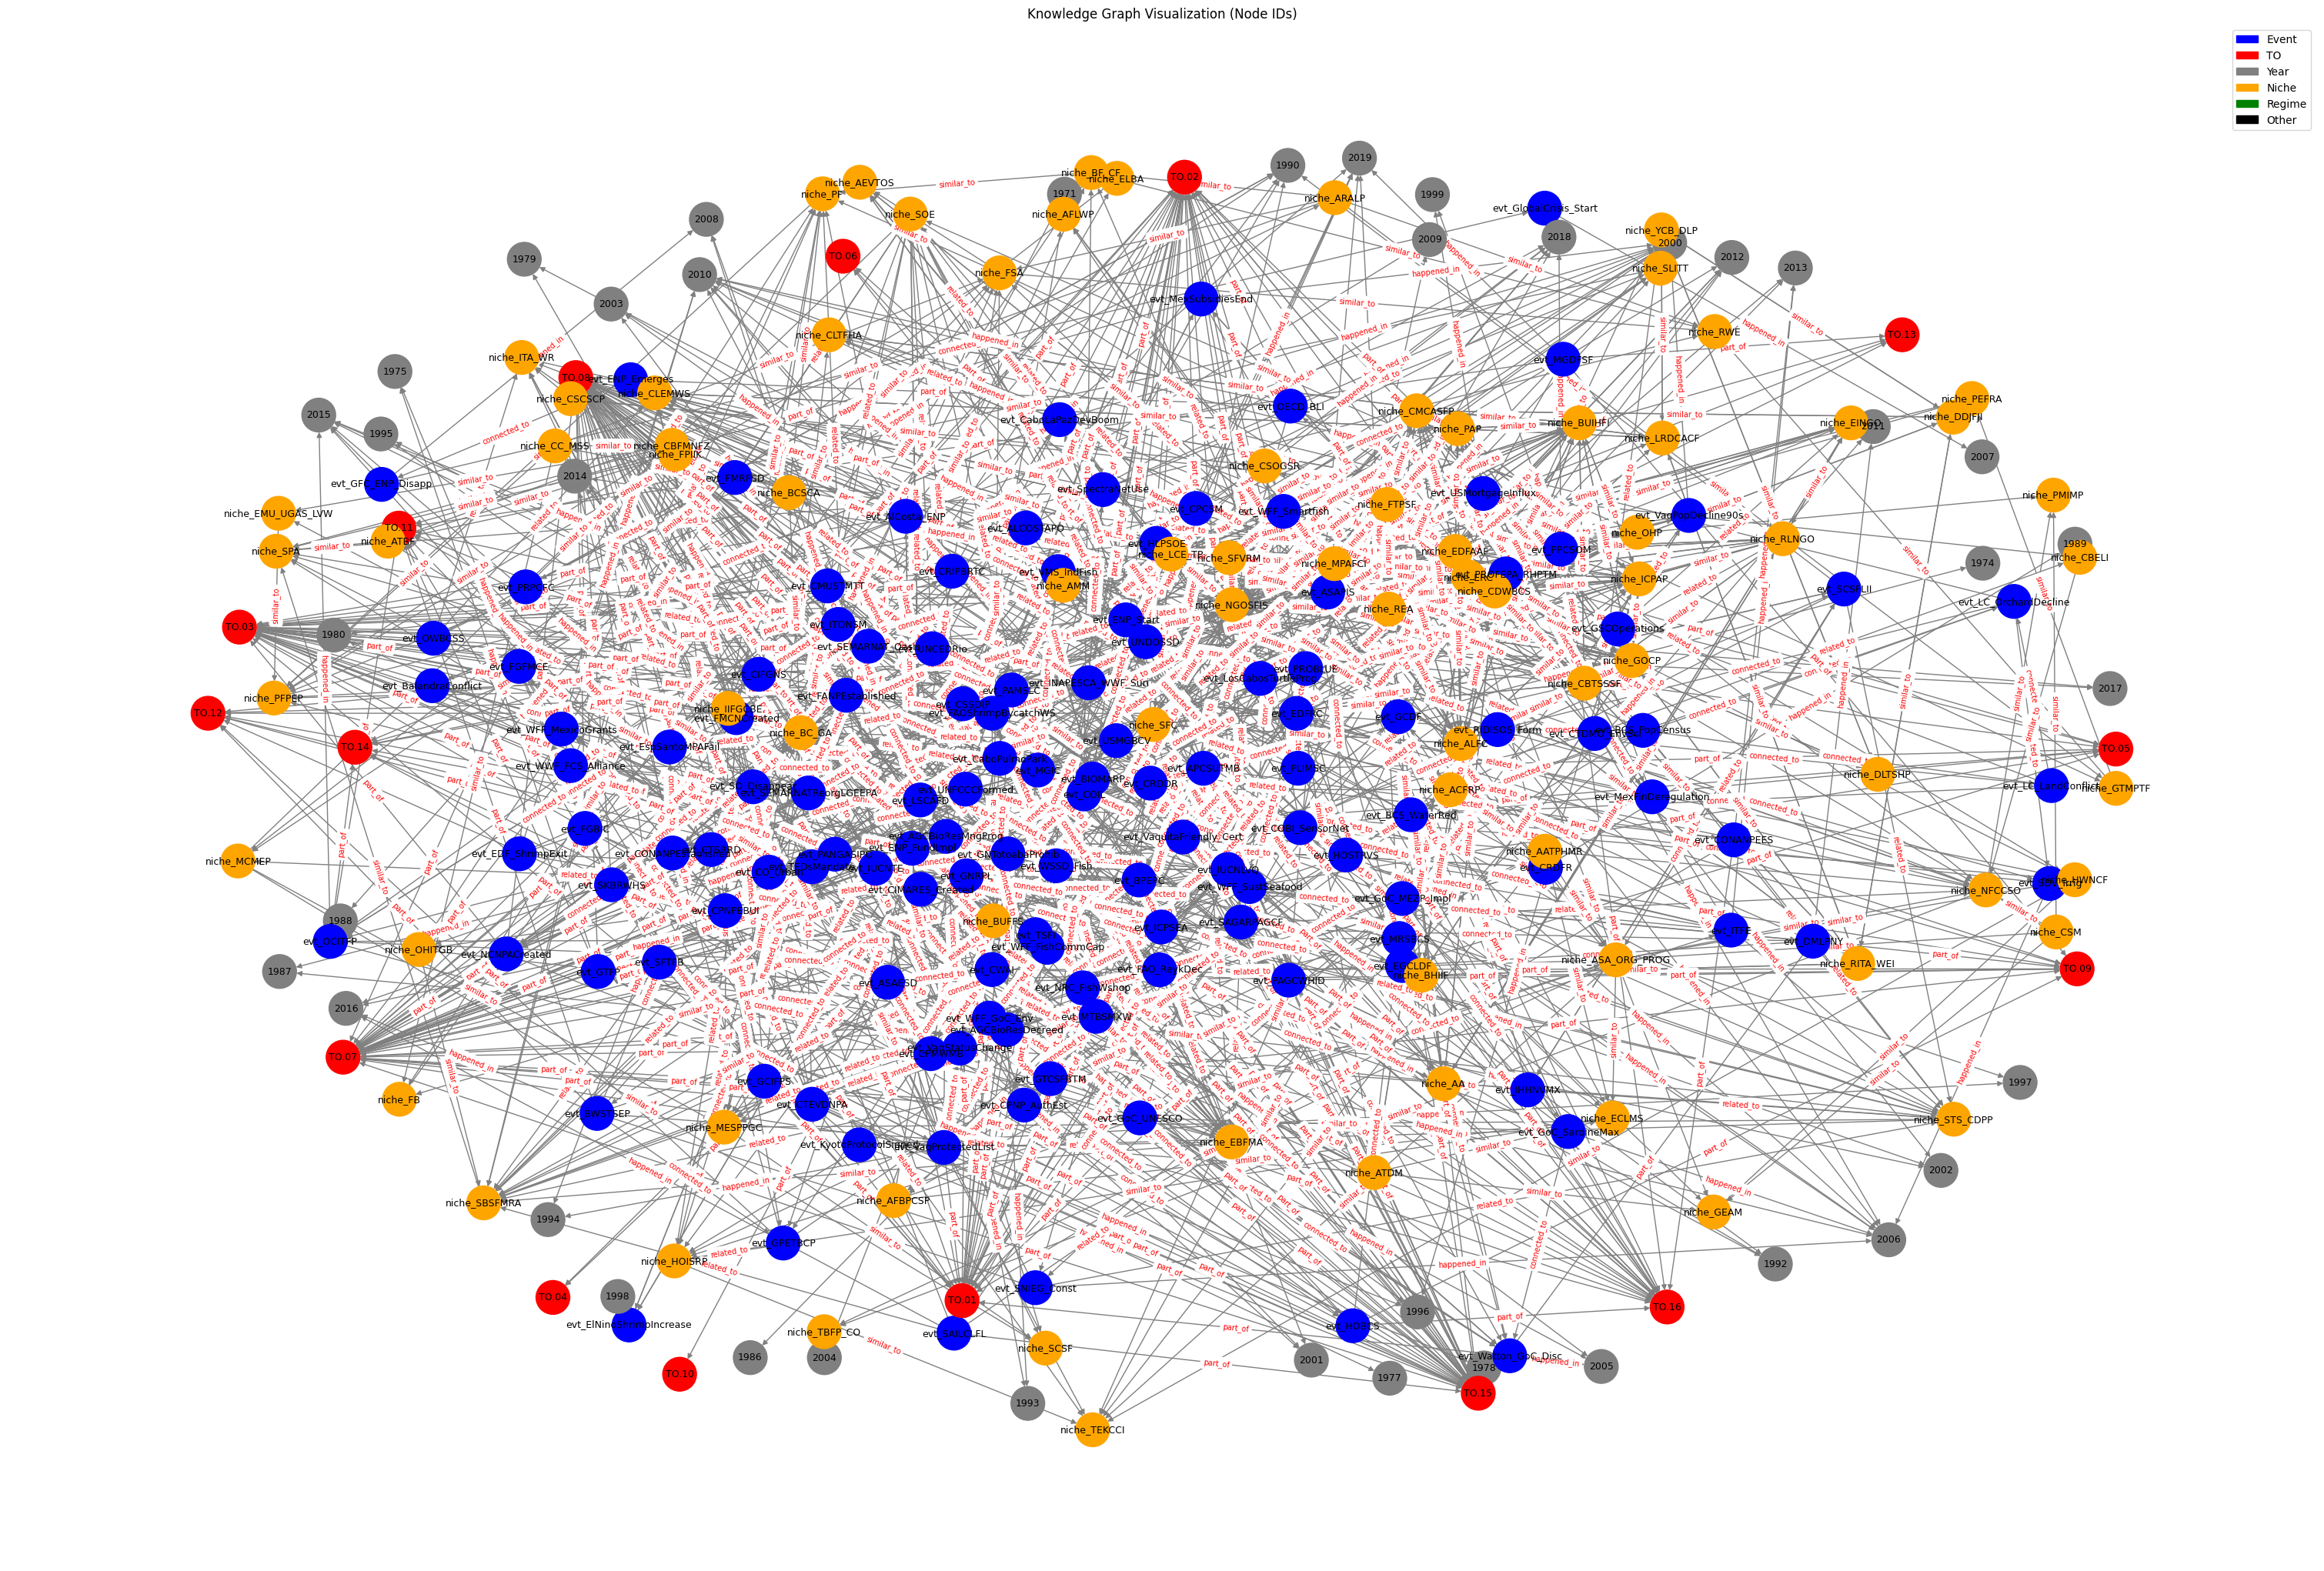

Node ID to Description Mapping (visualized nodes):


📁 Graph exported to: data\output\graph_ALL_depth1_all0_full_20250727_2130.json


In [ ]:
# This function plots the knowledge graph based on the relationships and descriptions provided.
# It allows for focusing on a specific node, controlling the depth of neighbors shown, and whether
# - `focus_node`: If set, the graph will center around this node and show its immediate neighbors up to the specified depth.
# - `depth`: Controls how many layers of neighbors to include around the focus node.
# - `show_all`: If True, the graph will include all nodes and relationships; if False, it will only show the subgraph around the focus node.
# - `figsize`: Controls the size of the plot.
# Example usage:
plot_knowledge_graph(
    all_relationships,
    event_desc_map,
    niche_desc_map,
    regime_desc_map,
    to_desc_map,
    year_ids,
    figsize=(30, 20)  # Adjust figure size as needed
)

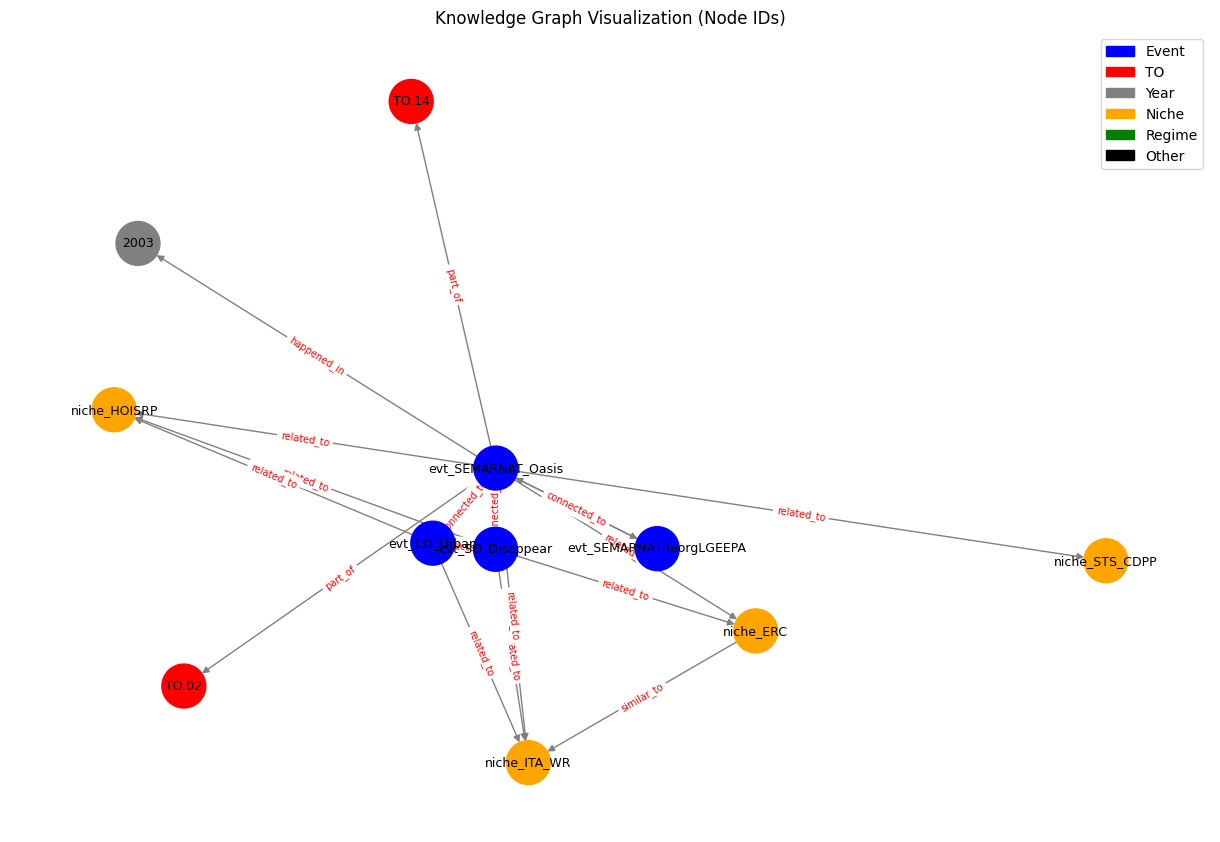

Node ID to Description Mapping (visualized nodes):


📁 Graph exported to: data\output\graph_evt_SEMARNAT_Oasis_depth1_all0_full_20250727_2131.json


In [ ]:
plot_knowledge_graph(
    all_relationships,
    event_desc_map,
    niche_desc_map,
    regime_desc_map,
    to_desc_map,
    year_ids,  # Example year range, adjust as needed
    focus_nodes=['evt_SEMARNAT_Oasis'],  # Change to a specific event ID to focus on that node
    depth=1,  # Increase depth to see more connections
    show_all=False,  # Set to False to only show the subgraph around the focus node
    figsize=(12, 8)  # Adjust figure size as needed
)

### 📋 Exploration from existing network data
Run this section if you want to visualize from existing json data

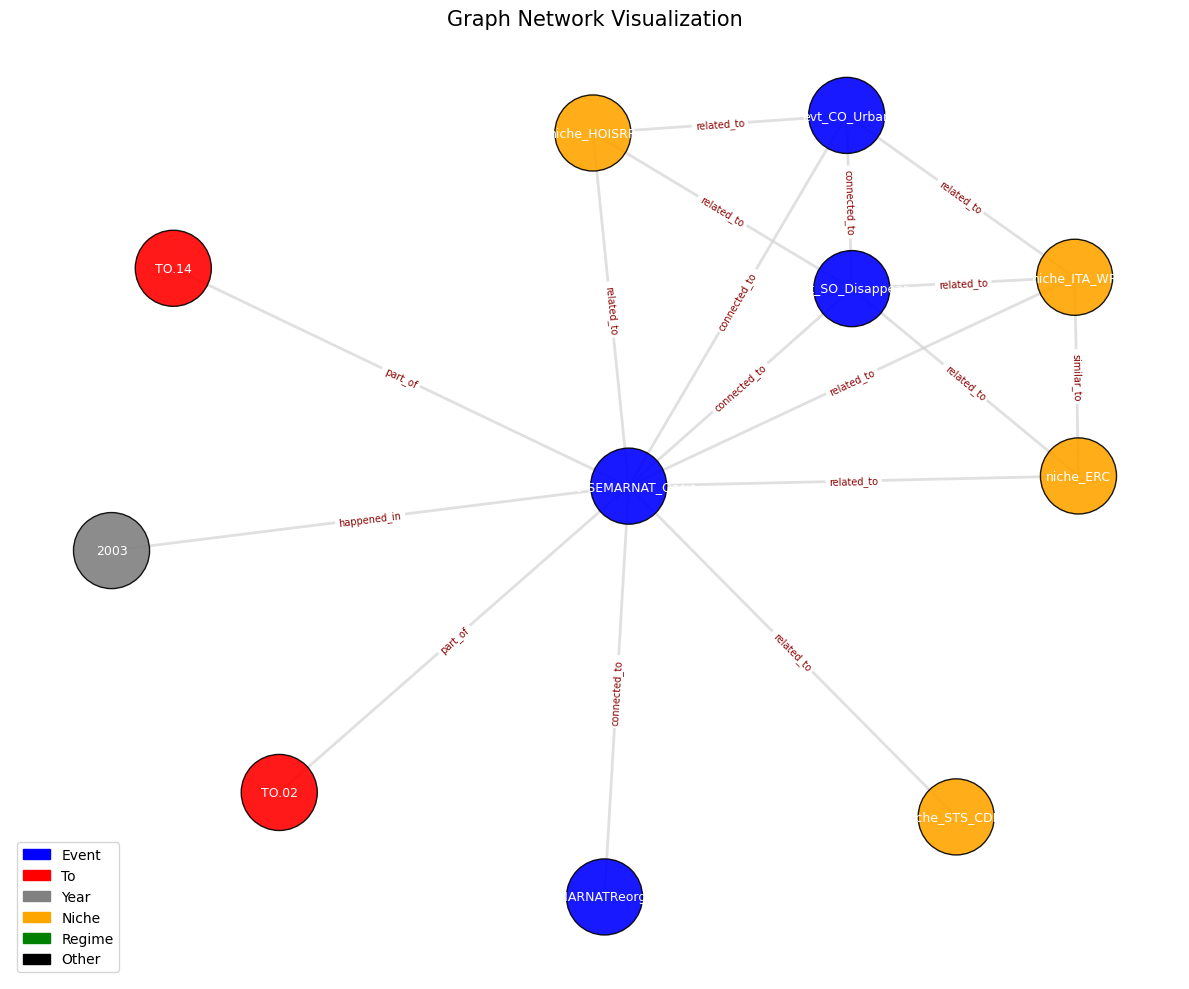

Node ID to Description Mapping (visualized nodes):


In [ ]:
# Example file path to visualize the graph network from a JSON file
file_path='data\output\graph_evt_SEMARNAT_Oasis_depth1_all0_full_20250727_1745.json'
visualize_graph_network_from_json(file_path)


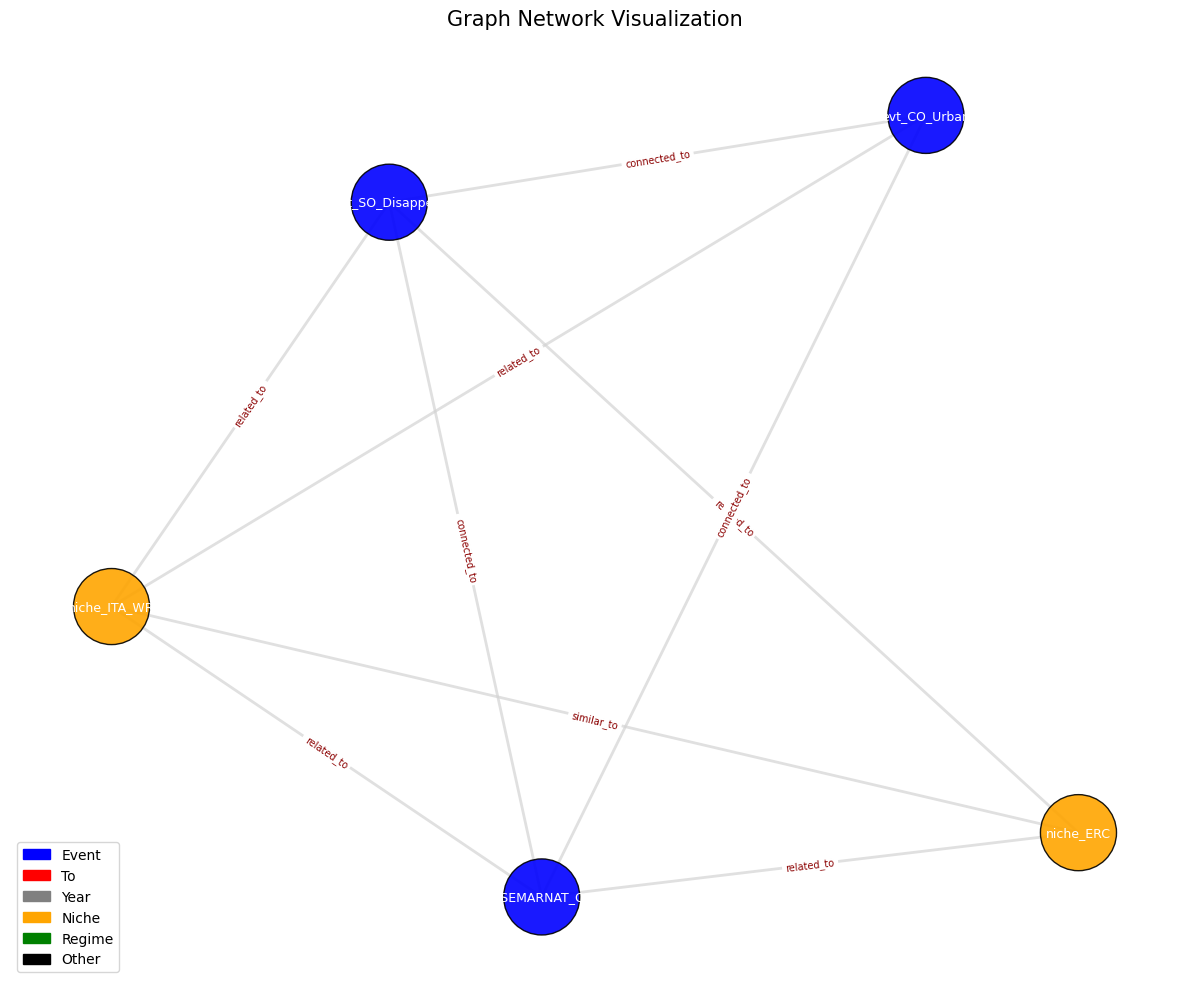

Node ID to Description Mapping (visualized nodes):


In [ ]:
file_path='data\output\graph_evt_SEMARNAT_Oasis_depth1_all0_full_20250727_1745.json'
visualize_graph_network_from_json(file_path, selected_nodes=["niche_ITA_WR"], depth=1)


### 🧪 SNA Example

In [ ]:
# example calculate SNA from a JSON file

def calculate_sna_from_json(json_data):
    """
    Calculate Social Network Analysis (SNA) metrics from JSON data containing nodes and edges.
    
    Args:
        json_data (dict): JSON data with 'nodes' and 'edges'.
    
    Returns:
        dict: Overall SNA metrics for the graph.
    """
    G = nx.Graph()

    # Add nodes
    for node in json_data.get("nodes", []):
        G.add_node(node["id"], type=node.get("type", "other"), description=node.get("description", ""))

    # Add edges
    for edge in json_data.get("edges", []):
        G.add_edge(edge["from"], edge["to"], relationship_type=edge.get("relationship_type", "connected"))

    # Calculate SNA metrics
    sna_metrics = {
        "average_degree_centrality": sum(nx.degree_centrality(G).values()) / G.number_of_nodes(),
        "average_betweenness_centrality": sum(nx.betweenness_centrality(G).values()) / G.number_of_nodes(),
        "average_closeness_centrality": sum(nx.closeness_centrality(G).values()) / G.number_of_nodes() if G.number_of_nodes() > 1 else 0,
        "graph_density": nx.density(G)
    }

    return sna_metrics

file_path='data\output\graph_evt_SEMARNAT_Oasis_depth1_all0_full_20250727_1745.json'
with open(file_path, 'r', encoding='utf-8') as f:
    json_data = json.load(f)

sna_metrics = calculate_sna_from_json(json_data)
print("SNA Metrics:")
for metric, values in sna_metrics.items():
    print(f"{metric}: {values}")



SNA Metrics:
average_degree_centrality: 0.30909090909090914
average_betweenness_centrality: 0.07676767676767678
average_closeness_centrality: 0.6113378365700346
graph_density: 0.3090909090909091


### 🤖 **AI-Assisted Q\&A on Graph**

This feature lets you **ask natural language questions** about a selected graph you previously explored.

**How it works:**

1. Upload the `.json` file generated in the previous section.
2. Type your question (e.g., "Is there any evidence of coral conservation?").
3. The AI will respond with:

   * 🧠 An **answer** to your question
   * 🔗 A **filtered graph** with only relevant nodes and relationships
   * 📋 A **table** of nodes included in the answer
   * 💾 A new JSON file saved to:
     `📁 data/output/graph_...json`

> 💡 *Tip: Remember the filename you used so you can easily upload the correct file when querying.*

In [ ]:
def visualize_graph_from_json(json_data, figsize=(12, 8)):
    # Load JSON
    data=json_data

    nodes = data.get('nodes', [])
    edges = data.get('edges', [])

    # Build graph
    G = nx.DiGraph()
    node_types = []
    node_colors = []

    color_map = {
        'Event': 'blue',
        'TO': 'red',
        'Year': 'gray',
        'Niche': 'orange',
        'Regime': 'green',
        'Other': 'black'
    }

    for node in nodes:
        nid = node['id']
        ntype = node.get('type', 'Other')
        ndesc = node.get('description', nid)
        G.add_node(nid, type=ntype, description=ndesc)
        node_types.append(ntype)
        node_colors.append(color_map.get(ntype, 'gray'))

    for edge in edges:
        G.add_edge(edge['from'], edge['to'], relationship_type=edge.get('relationship_type', ''))

    # Draw graph
    plt.figure(figsize=figsize)
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_size=700, node_color=node_colors, edge_color='gray', arrows=True)

    edge_labels = {(u, v): d['relationship_type'] for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    plt.title("Knowledge Graph from JSON")

    # Add legend
    legend_patches = [mpatches.Patch(color=color_map[k], label=k) for k in color_map]
    plt.legend(handles=legend_patches, loc='best')
    plt.show()

    # Display table
    mapping = [{'id': n['id'], 'description': n.get('description', n['id']), 'type': n.get('type', 'Other')} for n in nodes]
    df = pd.DataFrame(mapping).sort_values(by=['type', 'id'])
    print("Node ID to Description Mapping:")
    display_scrollable_dataframe(df)

    # Export filtered graph
    filename = f"graph_qna_{datetime.now().strftime('%Y%m%d_%H%M')}.json"
    out_path = os.path.join('data', 'output', filename)
    # os.makedirs(os.path.dirname(out_path), exist_ok=True)
    with open(out_path, 'w', encoding='utf-8') as f:
        json.dump({"nodes": nodes, "edges": edges}, f, ensure_ascii=False, indent=2)
    print(f"📁 Exported visualized graph to: {out_path}")

In [ ]:
from typing import Union

def analyze_graph_with_question(
    json_filepath: str,
    query: str,
    model,
    visualize_graph_from_json,
    timeout: int = 600
) -> Union[dict, None]:
    """
    Analyze a knowledge graph stored in a JSON file using a natural language query.
    
    Parameters:
    - json_filepath: str, path to the JSON file containing 'nodes' and 'edges'
    - query: str, the natural language question to ask about the graph
    - model: callable, should support `.generate_content(prompt, request_options={})`
    - visualize_graph_from_json: callable, function that accepts parsed JSON and renders the graph
    - timeout: int, timeout for model response in seconds (default: 600)
    
    Returns:
    - dict: final structured response from second model pass
    - None: if no valid JSON is returned
    """
    # Step 1: Load graph JSON
    with open(json_filepath, 'r', encoding='utf-8') as f:
        graph_data = json.load(f)

    # Step 2: First round filtering prompt
    context = f"""
Nodes:
{json.dumps(graph_data['nodes'], indent=2)}

Edges:
{json.dumps(graph_data['edges'], indent=2)}
"""
    prompt = f"""
You are a knowledge graph assistant. Analyze the following JSON-formatted graph structure:

{context}

Question: {query}

Instructions:
- Return only relevant edges and nodes that relate to the question.
- Provide the answer in a structured JSON format without any extra commentary or markdown.
- Your output should be directly usable with `json.loads()`.
"""
    response = model.generate_content(prompt, request_options={"timeout": timeout})

    # Step 3: Parse first response
    try:
        json_start = response.text.find("```json")
        json_end = response.text.find("```", json_start + 1)
        if json_start != -1 and json_end != -1:
            result_json_str = response.text[json_start + 7:json_end]
        else:
            result_json_str = response.text.strip()
        result_data = json.loads(result_json_str)
    except Exception as e:
        print(f"❌ Failed to parse response as JSON: {e}")
        return None   

    # Step 4: Second prompt with filtered graph context
    filtered_context = f"""
Nodes:
{json.dumps(result_data.get('nodes', []), indent=2)}

Edges:
{json.dumps(result_data.get('edges', []), indent=2)}
"""

    second_prompt = f"""
You are a knowledge graph assistant. Based on the **filtered** JSON-formatted graph structure below, provide a concise answer to the question.

{filtered_context}

Question: {query}

Instructions:
- Respond concisely and directly based on the filtered graph context.
- If the graph provides evidence, explain it briefly.
- If there is no evidence, say so clearly.
- Format your answer as markdown.
"""
    followup_response = model.generate_content(second_prompt, request_options={"timeout": timeout})
    
    # Step 5: Display final answer
    print("🔍 Final Answer Based on Filtered Graph:\n")
    display(Markdown(followup_response.text.strip()))
    # Step 6: Visualize filtered graph
    visualize_graph_from_json(result_data, figsize=(12, 8))

    return result_data


In [ ]:
# result = analyze_graph_with_question(
#     json_filepath="D:\MASTER STUDY-UU\Work\Research Assistant\Deep Transition\Playbook Metrics\data\output\graph_ALL_depth1_all1_20250716_1458.json",
#     query="Tell me if there is any evidence of coral conservation",
#     model=model,  # your language model instance
#     visualize_graph_from_json=visualize_graph_from_json
# )


In [ ]:

def interactive_graph_analysis(model, visualize_graph_from_json):
    """
    Launches an interactive UI for selecting a graph JSON file and entering a query.
    
    Parameters:
    - model: the language model (must support `.generate_content()`)
    - visualize_graph_from_json: function to render a graph from JSON
    """
    
    # File picker
    file_picker = widgets.FileUpload(accept='.json', multiple=False)
    query_input = widgets.Textarea(
        value='',
        placeholder='Enter your question about the graph...',
        description='Query:',
        layout=widgets.Layout(width='100%', height='100px')
    )
    submit_button = widgets.Button(description="Run Analysis", button_style='primary')
    output = widgets.Output()

    

    from IPython.display import clear_output, display, HTML

    def on_submit_clicked(b):
        output.clear_output()
        with output:
            file_value = file_picker.value

            if not file_value:
                print("⚠️ Please upload a JSON file.")
                return
            if not query_input.value.strip():
                print("⚠️ Please enter a query.")
                return

            # Display loading message
            display(HTML("<b>⏳ Processing graph and query, please wait...</b>"))

            try:
                # Handle tuple or dict structure
                if isinstance(file_value, dict):  # JupyterLab-style
                    file_info = list(file_value.values())[0]
                    uploaded_filename = list(file_value.keys())[0]
                elif isinstance(file_value, tuple):  # Classic Notebook
                    file_info = file_value[0]
                    uploaded_filename = file_info.get('name', 'uploaded_graph.json')
                else:
                    print("❌ Unsupported file upload format.")
                    return

                content = file_info['content']

                # Save to a temporary file
                with tempfile.NamedTemporaryFile(delete=False, suffix=".json", mode='wb') as tmp_file:
                    tmp_file.write(content)
                    temp_path = tmp_file.name

                # Clear loading and run analysis
                clear_output(wait=True)
                result = analyze_graph_with_question(
                    json_filepath=temp_path,
                    query=query_input.value,
                    model=model,
                    visualize_graph_from_json=visualize_graph_from_json
                )

            except Exception as e:
                clear_output(wait=True)
                print("❌ Error:", str(e))

    submit_button.on_click(on_submit_clicked)

    display(widgets.VBox([
        widgets.Label("Upload a knowledge graph JSON file:"),
        file_picker,
        query_input,
        submit_button,
        output
    ]))


#### Ask me anything!

In [ ]:
interactive_graph_analysis(model=model, visualize_graph_from_json=visualize_graph_from_json)


In [ ]:
interactive_graph_analysis(model=model, visualize_graph_from_json=visualize_graph_from_json)